<a href="https://colab.research.google.com/github/ssingh1187/Resource-List-Docs/blob/master/Copy_of_differential_geometry_(with_neat_visualizations).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-2.0-preview

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


FIGSIZE = (9, 7)
print(tf.__version__)

2.0.0-dev20190128


# Notes on differential geometry

These are notes from a PyMC journal club on January 18, 2019, in preparation for reading Michael Betancourt's new article on [A Geometric Theory of Higher-Order Automatic Differentiation](https://arxiv.org/abs/1812.11592), which makes extensive use of differential geometry. These notes are essentially an elaboration of chapter 0, section 1-3 in Manfredo Do Carmo's _Riemannian Geometry_.

This is pretty long! Your best bet might be to get the book, read through the first ~10 pages, then refer to this notebook. You might also view the notebook as an example of using TensorFlow 2.0, and some matplotlib functions - I learned about `plt.quiver` and that the 3d plotting is pretty easy now.

## Big Picture

- We can calculate derivatives of functions from $\mathbb{R}^n \rightarrow \mathbb{R}^m$, using calculus
- If we have a real-valued function on some set with nice properties (a _smooth manifold_), we can still do a lot of calculus
- We do our calculations using a parameterization, and are interested in what happens when we change that parameterization

###Function composition
A lot of what we will do is "pushing" functions, also called function composition. That is, if $f : A \rightarrow B$ and $g: B \rightarrow C$, then $g \circ f : A \rightarrow C$.

I try to provide working code examples for a lot of the concepts. For an example of function composition, consider:

In [0]:
def powers(t):
    """Function from R -> R^4"""
    return [t ** j for j in range(4)]

def my_sum(*elements):
    """Function from R^n -> R"""
    return sum(elements)

def composition(t):
    """Function from R -> R"""
    return my_sum(*powers(t))

print(powers(2))
print(my_sum(*powers(2)))
print(composition(2))

[1, 2, 4, 8]
15
15


## Review of calculus

We start by remembering derivatives and gradients from calculus, _and_ showing how to perform and visualize these calculations using tensorflow and matplotlib. We are limited to 3 dimensions for visualization, so we will look at functions 
- $\mathbb{R} \rightarrow \mathbb{R}$
- $\mathbb{R} \rightarrow \mathbb{R}^2$

and consider what gradients mean in each of these places.

### Functions $\mathbb{R} \rightarrow \mathbb{R}$

These are usually covered in single variable calculus, and allow you to miss some of the "vector"-y stuff that happens in higher dimensions. In particular, I will plot the derivative as a bunch of tangent arrows on the function, rather than as a separate graph, to emphasize that the gradient is a vector at a point.

In [0]:
t = tf.linspace(-2 * np.pi, 2  * np.pi, 100)

with tf.GradientTape() as g:
    g.watch(t)
    f = tf.cos(t)
grad = g.gradient(f, t)

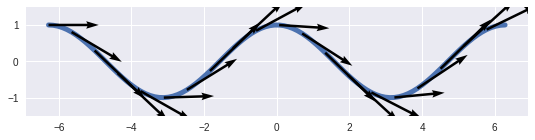

In [0]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(t, f, lw=5)

# plot looks busy with too many arrows
ax.quiver(t[::5], f[::5], 1, grad[::5], 
          units='width', 
          width=0.005, 
          scale=10, 
          zorder=20);
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal');  # otherwise the angles look wrong

Notice that the gradient is the derivative, and is a function from $\mathbb{R} \rightarrow \mathbb{R}$, $(\cos)`(t) = -\sin t$.

### Functions $\mathbb{R} \rightarrow \mathbb{R}^2$

These are parametric curves, 
$$
f(t) = (x(t), y(t))
$$
and now our gradient will be the elementwise gradient,
$$
f'(t) = (x'(t), y'(t))
$$

In [0]:
t = tf.linspace(0., 2 * np.pi, 50)

# `persistent=True` because we extract two gradients here
with tf.GradientTape(persistent=True) as g:
    g.watch(t)
    f = [tf.cos(t), tf.sin(t)]
    
# Note: `g.gradient(f, t)` returns `sum(grads)`
grads = [g.gradient(func, t) for func in f]

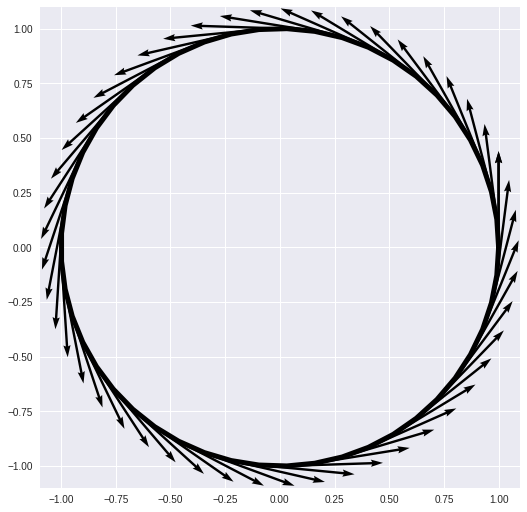

In [0]:
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.plot(f[0], f[1], 'k-', lw=5);
ax.quiver(f[0], f[1], *grads, scale=5, width=0.005)
ax.set_aspect('equal');  # otherwise the angles look wrong

Notice that the gradient is a _function_ from $[0, 2 \pi] \rightarrow \mathbb{R}^2$:

$$
f'(t) = (-\sin t, \cos t)
$$

## Surfaces

I pick up now with Chapter 0 of Do Carmo's _Differential Geometry_. The fact that I am emphasizing here is that:

**In calculus, we prove that a change of parameters is differentiable. In differential geometry, that is part of the definition.**

In order to emphasize this, we should consider:

- What does a change of parameters even mean?
- What does it mean to be differentiable?

I will say right away that I use the word "differentiable" because it sounds easier than "diffeomorphism", but really I mean "diffeomorphism". That word gets defined below.

### Functions $\mathbb{R}^2 \rightarrow \mathbb{R}$

First we need to define nice, invertible functions:

**Definition (homeomorphism)** A function $\mathbf{x}$ is a _homeomorphism_ if 

- $\mathbf{x}$ is 1-to-1 and onto
- $\mathbf{x}$ is continuous
- $\mathbf{x}^{-1}$ is continuous

**Discussion** In most examples I have seen, we _define_ the range of a map to be wherever it maps, so it is mechanically a surjective (onto) mapping. So if we want to make our parametric map of the circle above into a homeomorphism, we are mostly doing bookkeeping of domains and ranges:

Consider 

$$
\mathbf{x}: \mathbb{R} \rightarrow \mathbb{R}^2 = (\cos t, \sin t)
$$
    
Note that this is not injective (1-to-1), since $\mathbf{x}(0) = \mathbf{x}(2 \pi) = (1, 0)$. It is also not surjective (onto), since no value of $t$ maps to $(0, 0) \in \mathbb{R}^2$.
    
Then we instead define 
$$
\mathbf{x}: [0, 2 \pi) \rightarrow \{\mathbf{x}(t) \in \mathbb{R}^2: t \in [0, 2 \pi)\} = (\cos t, \sin t)
$$

Now this is 1-to-1, onto, and continuous, and has an inverse for each point on the circle:

$$
\mathbf{x}^{-1}(x_1, x_2) = \arctan \frac{x_1}{x_2} + \frac{\pi}{2},
$$

where we would do some bookkeeping for $x_2 = 0$ and making sure $\arctan$ mapped to $[0, 2 \pi)$.


Now we can provide Do Carmo's definition of a regular surface:

**Definition (regular surface)** $S \subset \mathbb{R}^3$ is a _regular surface_ if, for every $p \in S$, there exists a neighborhood $V$ of $p$ and $\mathbf{x} : U \subset \mathbb{R}^2 \rightarrow V \cap S$ so that 

- $\mathbf{x}$ is a differentiable homeomorphism
- The differential $(d\mathbf{x})_q : \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is injective for all $q \in U$.
    
    
**Discussion** This definition defines a surface as a subset of $\mathbb{R}^3$ as being a surface: the map $\mathbf{x}$ is not the surface! It is important, and will be part of the definition of a manifold, that there are many different maps that give the same surface.

Note that the differential $(d \mathbf{x})_q$ is a $3\times 2$ matrix, and _injectivity_ means that is has full rank. The discussion of neighborhoods above should remind you of the discussion about homeomorphisms above (bookkeeping so the maps are 1-to-1 and onto), and continuity conditions for those familiar with topology (this connection will not be needed to understand the rest of this).

Let's look at an example of a surface to motivate a concrete discussion:

In [0]:
from mpl_toolkits import mplot3d

In [0]:
X, Y = tf.meshgrid(tf.linspace(-2., 2., 50), tf.linspace(-2., 2., 50))
hyperbolic_parabaloid = lambda x, y: 1 - x**2 + y**2 # look it up

with tf.GradientTape() as g:
    g.watch([X, Y])
    f = hyperbolic_parabaloid(X, Y)

grad = g.gradient(f, [X, Y])

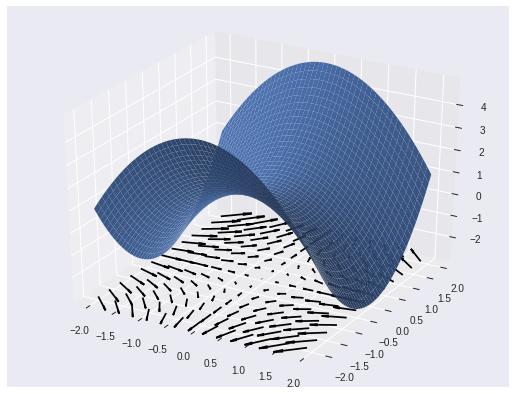

In [0]:
indices = (slice(None, None, 4), slice(None, None, 4))
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, f, shade=True, linewidth=2, antialiased=True);
ax.quiver(X[indices], Y[indices], ax.get_zlim3d()[0], # position
          grad[0][indices], grad[1][indices], 0,  # direction
          color='black', 
          zorder=-100, 
          length=0.1);

If we claim the thing plotted above is a _regular surface_, we need to show every point has a neighborhood that is the image of a differentiable homeomorphism with an injective differential. Phew!

Luckily, we claim that _all_ points have the same neighborhood and the same differentiable homeomorphism. Specifically, the set $U \subset \mathbb{R}^2$ is $(-2, 2) \times (-2, 2)$, and in the code, we generate this with `tf.meshgrid`. Also, the map $\mathbf{x}: U \rightarrow S$ is the function `hyperbolic_parabaloid`, given by 

$$
\mathbf{x}(x_1, x_2) = (x_1, x_2, 1 - x_1^2 + x_2^2),
$$

which is continuous, because polynomials are. The differential is given by

$$
(d\mathbf{x})_{(x_1, x_2)} = \begin{bmatrix}
    1       & 0  \\
    0       & 1 \\
    -2x_1 & 2x_2
\end{bmatrix}
$$

The fact that it exists and is continuous means that $\mathbf{x}$ is differentiable, and it has rank 2 (i.e., full rank, i.e., "is injective") for any $(x_1, x_2)$ because the columns are independent.

We still need to show that the inverse is continuous. But the inverse is so silly it feels like cheating, and is given by 

$$
\mathbf{x}^{-1}(y_1, y_2, y_3) = (y_1, y_2)
$$

In words: just project the surface onto the plane to get the inverse.

**Definition (parameterization)** A map $\mathbf{x}$ that defines a regular surface $S$ in a neighborhood of $p \in S$ is called a _parameterization of $S$ at $p$_.

**Discussion** Note that in the definition of a regular surface, $S$ did not care about $U$. So we can trivially write down another parameterization of the exact same surface $S$, but with $U = (-4, 4) \times (-4, 4)$.

In [0]:
X, Y = tf.meshgrid(tf.linspace(-4., 4., 50), tf.linspace(-4., 4., 50))
hyperbolic_parabaloid_param2 = lambda x, y: 1 - (x / 2)**2 + (y / 2)**2 # look it up

with tf.GradientTape() as g:
    g.watch([X, Y])
    f = hyperbolic_parabaloid_param2(X, Y)

grad = g.gradient(f, [X, Y])

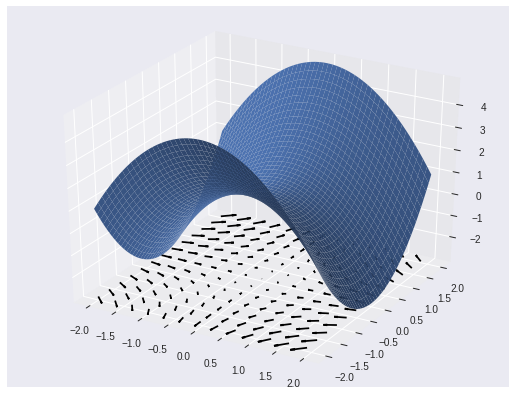

In [0]:
indices = (slice(None, None, 4), slice(None, None, 4))
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot_surface(X / 2, Y / 2, f, shade=True, linewidth=2, antialiased=True);
ax.quiver(X[indices] / 2, Y[indices] / 2, ax.get_zlim3d()[0], # position
          grad[0][indices], grad[1][indices], 0,  # direction
          color='black', 
          zorder=-100, 
          length=0.1);

### The highlight of multivariable differentiable calculus

Just like a homeomorphism is a continuous function with continuous inverse, a _diffeomorphism_ is a differentiable function with differentiable inverse. Do Carmo in fact assumes _smoothness_, so the function and its inverse have infinitely many derivatives.

**Theorem (important)** A change of parameters is a diffeomorphism.

This will be _part of the definition_ of a manifold, but it is _a theorem that is proved_ in a calculus course. We haven't defined a change of parameters yet!

**Definition (change of parameters)** If $\mathbf{x}_{\alpha} : U_{\alpha} \rightarrow S$, $\mathbf{x}_{\beta} : U_{\beta} \rightarrow S$ are two parameterizations of $S$, and $x_{\alpha}(U_{\alpha}) \cap x_{\beta}(U_{\beta}) = W \ne \varnothing$, then 
$$
x_{\beta}^{-1} \circ x_{\alpha} : x_{\alpha}^{-1}(W) \rightarrow \mathbb{R}^2
$$
is a _change of parameters_.

Remember that $x_{\beta}^{-1} \circ x_{\alpha}$ is a composition of two functions: first $x_{\alpha}$ maps points onto a surface, then $x_{\beta}^{-1}$ maps those points back to $\mathbb{R}^2$.

### Why is the change of parameters being a diffeomorphism so important?

It turns out that for most questions about a surface (or, soon, a manifold) do not depend on where it is sitting in $\mathbb{R}^3$. For example, in calculus, we often ask about the directional derivative of the height of a graph. Then we have our parameterization, $\mathbf{x}: \mathbb{R}^2 \rightarrow S \subset \mathbb{R}^3$, and the height function, $f(s_1, s_2, s_3): S \rightarrow \mathbb{R}$, where $f(s_1, s_2, s_3) = s_3$. Then the gradient is actually just a calculation of the gradient of 
$$
f \circ \mathbf{x}: \mathbb{R}^2 \rightarrow \mathbb{R}
$$

We are interested in the gradient of $f$, a function on $S$, which should not need to know about $\mathbf{x}$, but it looks like it cares a lot about $\mathbf{x}$! The multidimensional chain rule looks like this:

$$
(d f \circ \mathbf{x})_{\mathbf{q}} = (df)_{\mathbf{x}(\mathbf{q})} \circ (d\mathbf{x})_{\mathbf{q}}
$$

As a dimension check, we expect 
- $(d f \circ \mathbf{x})_{\mathbf{q}}$ to be a $1 \times 2$ matrix,
- $(d\mathbf{x})_{\mathbf{q}}$ to be $3 \times 2$ matrix, and 
- $(df)_{\mathbf{x}(\mathbf{q})}$ to be a $1 \times 3$ matrix

Since matrices are the same as linear transformations, the $\circ$ in "$(df)_{\mathbf{x}(\mathbf{q})} \circ (d\mathbf{x})_{\mathbf{q}}$" is a matrix multiplication.

**Exercise to the reader** Show that if $x_{\alpha}$ and $x_{\beta}$ are two parameterizations of $S$, then $(d f \circ x_{\alpha})_{\mathbf{q}} = (d f \circ x_{\beta})_{x_{\beta}^{-1} \circ x_{\alpha}(\mathbf{q})}$

This exercise shows that the gradients are independent of the parameterizations!

## Differentiable Manifolds

Bumping up to differentiable manifolds, not much changes, except we no longer assume we know how to do calculus in the space the surface sits in:

**Definition (differentiable manifold)** A _differentiable manifold_ is a set $M$ and a family of injective mappings $\mathbf{x}_{\alpha}: U_{\alpha} -> M$ so that

1. $\bigcup_{\alpha}\mathbf{x}_{\alpha}(U_{\alpha}) = M$
2. For any $\alpha, \beta$ with $\mathbf{x}_{\alpha}(U_{\alpha}) \cap \mathbf{x}_{\beta}(U_{\beta}) = W$, then:
  - $\mathbf{x}_{\alpha}^{-1}(W)$ and $\mathbf{x}_{\beta}^{-1}(W)$ are open sets 
  - $\mathbf{x}_{\beta}^{-1} \circ \mathbf{x}_{\alpha}$ is differentiable
3. the collection of maps is maximal

**Discussion** We call this collection of maps $\{\mathbf{x}_{\alpha}\}$ an _atlas_. This is a technical sounding definition, but the only two differences is that we require a change of parameters to be differentiable, which is important, and we require the atlas to be _maximal_, which just means that any map that satisfies the other conditions is in the atlas. This makes writing proofs easier, and can be mostly ignored.


### Example 

A (almost) parameterization of the sphere is 

$$
\mathbf{x}(\phi, \theta) = (\sin \phi \cos \theta, \sin \phi \cos \phi, \cos \phi)
$$

Note that there's some bookkeeping to be done around the north and south pole: either nothing maps there (i.e., $\mathbf{x}: (0, 2\pi) \times (0, 2\pi) \rightarrow S$), meaning the sphere is not covered, or lots of points map there (i.e., $\mathbf{x}: [0, 2\pi] \times [0, 2\pi] \rightarrow S$), and $\mathbf{x}$ is not injective.

In [0]:
phi, theta = tf.meshgrid(tf.linspace(0., 2 * np.pi, 50), tf.linspace(0., 2. * np.pi, 50))
X = tf.sin(phi) * tf.cos(theta)
Y = tf.sin(phi) * tf.sin(theta)
Z = tf.cos(phi)

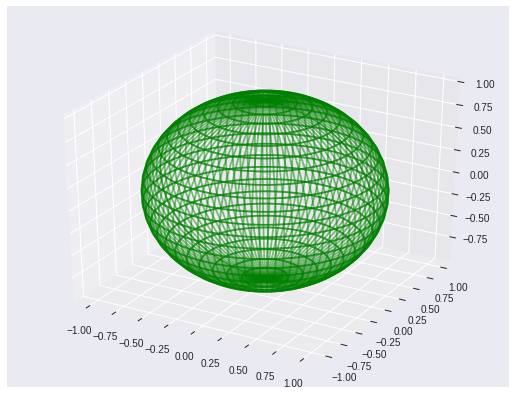

In [0]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, alpha=0.5, color='green');

Two more parameterizations are 

$$
\mathbf{x}_{\alpha}(x_1, x_2) = \sqrt{1 - x_1^2 - x_2^2}
$$

$$
\mathbf{x}_{\beta}(x_1, x_2) = -\sqrt{1 - x_1^2 - x_2^2}
$$

here there's some care to be had around the equator.

In [0]:
x1, x2 = tf.meshgrid(tf.linspace(-1., 1., 100), tf.linspace(-1., 1., 100))
Xa = tf.sqrt(1 - x1 ** 2 - x2 ** 2)
Xb = -tf.sqrt(1 - x1 ** 2 - x2 ** 2)

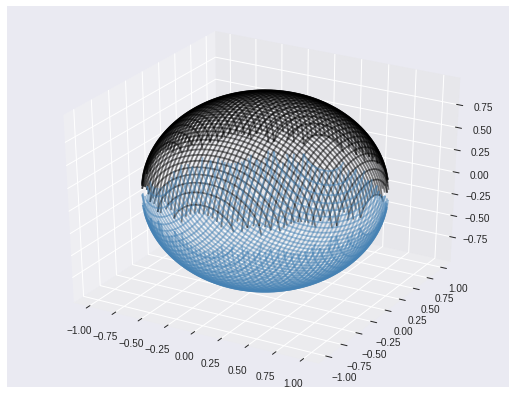

In [0]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot_wireframe(x1, x2, Xa, alpha=0.5, color='k');
ax.plot_wireframe(x1, x2, Xb, alpha=0.5, color='steelblue');

Since we assume our atlas is maximal, all three of these maps should actually be in it, as should all rotations of the maps, and subsets of the maps.

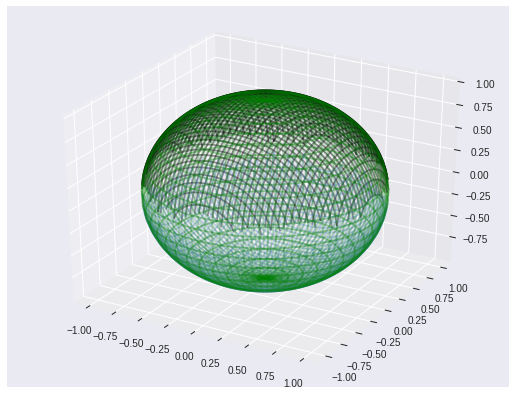

In [0]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot_wireframe(x1, x2, Xa, alpha=0.4, color='k');
ax.plot_wireframe(x1, x2, Xb, alpha=0.3, color='steelblue')
ax.plot_wireframe(X, Y, Z, alpha=0.2, color='green');


## Calculus on manifolds

We conclude with calculus on manifolds. The rule of thumb here is to push everything through a parameterization or its inverse, and do your calculus in $R^n$.

**Definition (differentiable map)** Given two differentiable manifolds, $M_{\alpha}$ with atlas $\{\mathbf{x}_{\alpha}\}$ and $M_{\beta}$ with atlas $\{\mathbf{y}_{\beta}\}$, a map $f: M_{\alpha} \rightarrow M_{\beta}$ is _differentiable_ at $p \in M_{\alpha}$ if there exists a parameterization $\mathbf{x} \in \{\mathbf{x}_{\alpha}\}$ and $\mathbf{y} \in \{\mathbf{y}_{\beta}\}$ so that
$$
\mathbf{y}^{-1} \circ f \circ \mathbf{x}
$$

is differentiable at $\mathbf{x}^{-1}(p)$.

**Definition (differentiable curve)** A differentiable function $\alpha: (-\epsilon, \epsilon) \subset \mathbb{R} \rightarrow M$ is called a _differentiable curve_ in the manifold $M$.

**Definition (tangent vector)** Let $\alpha$ be a differentiable curve on $M$, $\alpha(0) = p \in M$, let $\mathcal{D}$ be the differentiable functions on $M$ at $p$, and let $f$ be an element of $\mathcal{D}$. The _tangent vector_ to $\alpha$ is a function from $\mathcal{D} \rightarrow \mathbb{R}$, 
$$
\alpha'(0)f = \left. \frac{d(f \circ \alpha)}{dt} \right|_{t=0}
$$
The set of all tangent vectors at $p$ is denoted $T_pM$.

**Discussion** The tangent vector to a curve at a point eats functions and returns a real number. We will give $T_pM$ the structure so that it is a vector space.

**Example**: This is the parabaloid from earlier, with a curve lifted onto it, and the point `t=0` marked in red.

In [0]:
X, Y = tf.meshgrid(tf.linspace(-2., 2., 50), tf.linspace(-2., 2., 50))
hyperbolic_parabaloid = lambda x, y: 1 - x**2 + y**2 # look it up


t = tf.linspace(-1., 1., 100)
y = 1 + .5 * tf.cos(8 * t - 1)
f2 = hyperbolic_parabaloid(t, y)

with tf.GradientTape() as g:
    g.watch([X, Y])
    f = hyperbolic_parabaloid(X, Y)

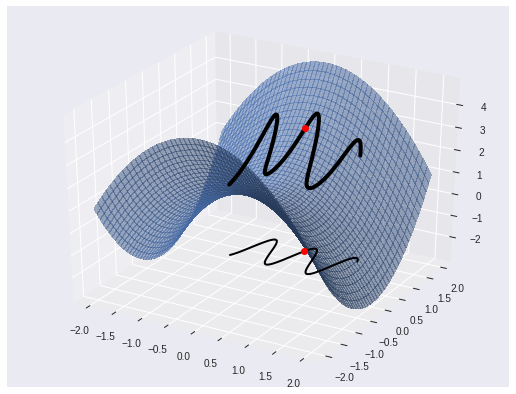

In [0]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot3D(t, y, f2, color='black', lw=4);
ax.plot_surface(X, Y, f, shade=True, linewidth=2, antialiased=False, alpha=0.5)

lower = ax.get_zlim3d()[0]
ax.plot3D(t, y, lower, color='black', lw=2);
mid = slice(50, 51)
ax.plot3D(t[mid], y[mid], f2[mid], color='red', marker='o');
ax.plot3D(t[mid], y[mid], lower, color='red', marker='o');

We can also look at the tangent vector to $\alpha$ of the height of the graph by plotting $f \circ \alpha : (-\epsilon, \epsilon) \rightarrow \mathbb{R}$:

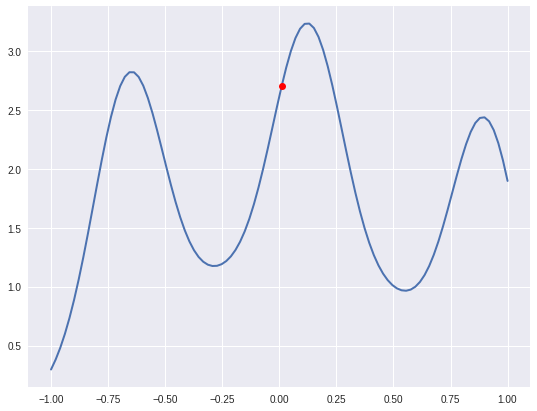

In [0]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(t, f2, lw=2)
ax.plot(t[mid], f2[mid], 'ro');

## The tangent vectors are a tangent space

If we write down a parameterization $\mathbf{x}: U \subset \mathbb{R}^n \rightarrow M$ of $M$ at $p = \mathbf{x}(0)$, then we can use the chain rule to write down the tangent vector to a curve $\alpha$ of a function $f$. Using the definition from earlier, 
$$
\alpha'(0)f = \left. \frac{d(f \circ \alpha)}{dt} \right|_{t=0},
$$

but $\alpha(t) = (x_1(t), \ldots, x_n(t))$, so 

$$
\alpha'(0)f = \left. \frac{d}{dt} f(x_1(t), \ldots, x_n(t)) \right|_{t=0}
$$

Applying the chain rule gives 


$$
\alpha'(0)f = \sum_{j=1}^n x_i'(0) \left( \frac{\partial f}{\partial x_j} \right) = \left(\sum_{j=1}^n x_i'(0) \left( \frac{\partial}{\partial x_j} \right)_0 \right) f
$$

It turns out (but can be checked!) that the vectors $\left( \frac{\partial}{\partial x_j} \right)_0$ are the tangent vectors of the coordinate curves in the parameterization given by $\mathbf{x}$. They define a basis of the vector space $T_pM$, associated with the parameterization $\mathbf{x}$.

## One last theorem and definition

**Definition (differential)** Suppose you have a differentiable mapping $\varphi: M_1 \rightarrow M_2$ between manifolds, $p \in M_1$, then the _differential of $\varphi$ at $p$_, is denoted $d_p\varphi: T_pM_1 \rightarrow T_{\varphi(p)}M_2$, is defined as follows:
1. Take a vector $\nu \in T_pM_1$
2. Take a curve $\alpha : (-\epsilon, \epsilon) \rightarrow M_1$ with $\alpha(0) = p$ and $\alpha'(0) = \nu$
3. Let $\beta = \varphi \circ \alpha$
4. Define $d_p\varphi(\nu) = \beta'(0)$

It is a theorem to show that $d_p\varphi$ does not depend on the choice of $\alpha$.
